# Fundamentals of Software Systems: Software Evolution, Part I - Assignment

**Nico Camillo Zala (18-753-202), Philippe Thomas Schmidli (17-742-305), Justin Simon Hehli (16-163-818)**


In [2]:
from pydriller import Repository, Git

## Task 2: Complexity hotspots

### Step 1: Collect a list of all Java files for release 3.6.0

To checkout the last major release 3.6.0, the below git commands were used. It was assumed that the release 3.6.0 corresponds to the tag 3.6.0 and branch 3.6. The repo was cloned locally to improve performance.

1. git clone https://github.com/apache/kafka.git
2. git checkout tags/3.6.0 -b 3.6

Two "helper" functions *df_to_csv* and *csv_to_df* were defined to write / read a pandas dataframe to / from a CSV file. These will be used later throughout the subtasks, to store and retrieve data from a local CSV file. This enables storing intermediate results and executing steps based on those.

The java files are collected using glob

In [2]:
# Create a list (pandas dataframe) of all .java files
import glob
import pandas as pd


def df_to_csv(df):
    df.to_csv('java_files.csv', index=False)


def csv_to_df():
    return pd.read_csv('java_files.csv')


java_files = []
for filename in glob.glob('./kafka/**/*.java', recursive=True):
    java_files.append(filename)

df = pd.DataFrame()
df['filename'] = java_files
df_to_csv(df)

pd.set_option('display.max_colwidth', None)
df.head()

,filename
0,./kafka\clients\src\main\java\org\apache\kafka\clients\ApiVersions.java
1,./kafka\clients\src\main\java\org\apache\kafka\clients\ClientDnsLookup.java
2,./kafka\clients\src\main\java\org\apache\kafka\clients\ClientRequest.java
3,./kafka\clients\src\main\java\org\apache\kafka\clients\ClientResponse.java
4,./kafka\clients\src\main\java\org\apache\kafka\clients\ClientUtils.java


### Step 2: Measure the complexity of all collected Java files using all four metrics

To measure the cyclomatic complexity (CC) and lines of code (LOC), the _lizard_ python package was used. Lizard enables measuring these complexities on a file directly, which simplified the task (simply iterate over files and call lizard functions())) compared to pydriller, which is very commit-centered. For some files, calculating these complexities resulted in an exception, which is why it was wrapped in a try/except block. If en error occurs during complexity computation, the complexity for a file is set to 0 (instead of None to simplify ordering etc. later, since we're only interested in high complexity values for our analysis)


In [4]:
# calculate CC / LOC for each file using lizard
import lizard

df = csv_to_df()
cc_list = []
loc_list = []
for i in df.index:
    cc = 0
    nloc = 0
    try:
        i = lizard.analyze_file(df.iloc[i]['filename'])
        nloc = i.function_list[0].__dict__['nloc']
        cc = i.function_list[0].__dict__['cyclomatic_complexity']
    except:
        pass
    cc_list.append(cc)
    loc_list.append(nloc)

df['cc'] = cc_list
df['loc'] = loc_list
df_to_csv(df)

The number of code changes (NCC) has already been for all changes between version 3.5.1 and 3.6.0 in Task 1. The resulting JSON file was used to extract this information for Task 2. Since not every Java file was necessarily changed in this timeframe, the NCC complexity is set to 0 if no record for a file could be found in the JSON file.

In [5]:
# set the NCC based on entity_info.json from task 1
import json

entity_info = {}
with open('./entity_info.json') as json_file:
    entity_info = json.load(json_file)

df = csv_to_df()
df['ncc'] = 0
for i in df.index:
    filename_ef = df.iloc[i]['filename'][len("./kafka\\\\"):]
    try:
        df.at[i, 'ncc'] = entity_info[filename_ef]["num of revisions"]
    except:
        df.at[i, 'ncc'] = 0

df_to_csv(df)

The indentation based complexity (IC) was calculated by traversing over each file's lines, and summing up the whitespace "blocks" at the start of a line. A block was defined as 4 spaces.

In [6]:
# calculate the IC
df = csv_to_df()
df['ic'] = 0
for i in df.index:
    ic = 0
    with open(df.iloc[i]['filename'], encoding="utf8") as f:
        for line in f:
            leading_spaces = len(line) - len(line.lstrip(' '))
            ic = ic + (leading_spaces / 4) if leading_spaces >= 4 else ic
        df.at[i, 'ic'] = ic

df_to_csv(df)

C:\Users\juhe9\AppData\Local\Temp\ipykernel_7164\3666256142.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '166.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[i, 'ic'] = ic


### Step 3: Visualize Hotspots

To visualize the hotspots, a heatmap is used. Since the list of all Java files has 4000+ entries, visualizing this whole list cannot be done while still being able to make sense of the resulting visualization. Thus, a collection consisting top 20 (highest complexity) entries per complexity (CC, LOC, NCC, IC) was computed from the original data set. Because the value ranges differ widely between the four complexity properties, they were first all scaled to a range of [0, 1], as to enable comparison between complexity categories. The resulting visualization is a heatmap with a white to dark-red color gradient, where files with the highest complexities can easily be identified by dark-red cell color.

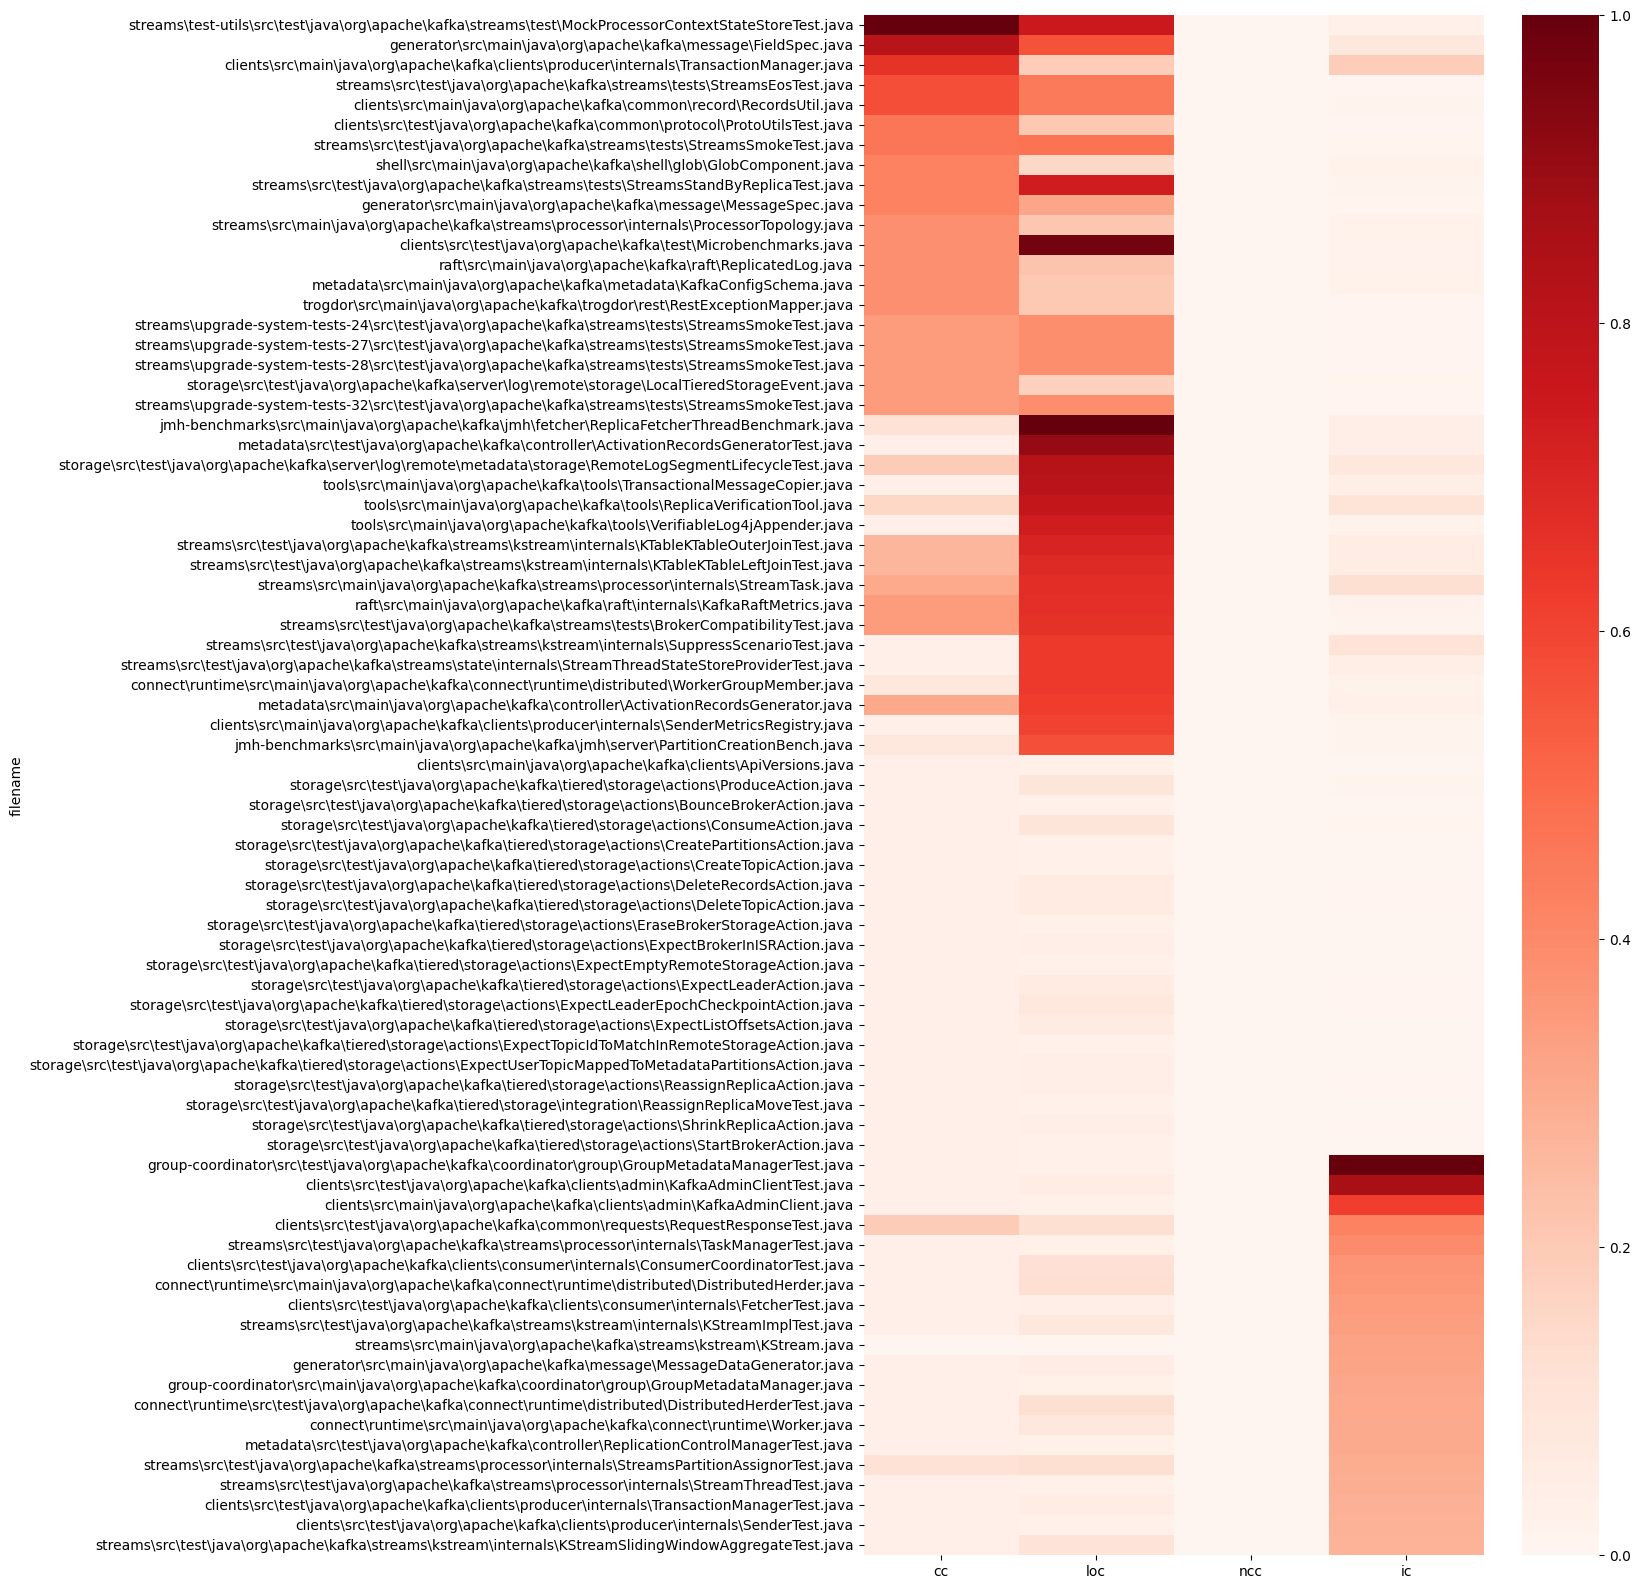

In [7]:
# create heatmap
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

top_metrics_df = csv_to_df()

mms = MinMaxScaler()
top_metrics_df[['cc', 'loc', 'ncc', 'ic']] = mms.fit_transform(
    top_metrics_df[['cc', 'loc', 'ncc', 'ic']])

top_metrics_df = pd.concat([
    top_metrics_df.sort_values('cc', ascending=False).head(20),
    top_metrics_df.sort_values('loc', ascending=False).head(20),
    top_metrics_df.sort_values('ncc', ascending=False).head(20),
    top_metrics_df.sort_values('ic', ascending=False).head(20),
])
top_metrics_df = top_metrics_df.drop_duplicates()

top_metrics_df['filename'] = top_metrics_df['filename'].str.replace(
    './kafka\\', '')
top_metrics_df = top_metrics_df.set_index('filename', drop=False)

fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(top_metrics_df[['cc', 'loc', 'ncc', 'ic']],
            cmap="Reds", xticklabels=True, yticklabels=True)
plt.show()

### Step 4: Complexity Trend Analysis

We manually selected 10 hotspots based on the above heatmap, which are files with dark-red cells in one of the complexity measures, meaning they have a high complexity in at least one measure.

To analyse the complexity change over time for these files, all commits of each of them were traversed, and the commit date plus cyclomatic complexity of the correspondig (modified) file in the commit were extracted from those commits. This data was the plotted in a line chart, with one line per file. A line thus shows the progression of a file's CC over time, with each data point per line corresponding to a commit.

For some files, the complexity stayed relatively constant, for others there is a clear upwards trend. We'd argue that those with the upwards trend are more critical and likely to be hotspots, since their complexity kept increasing and might increase further in the future.

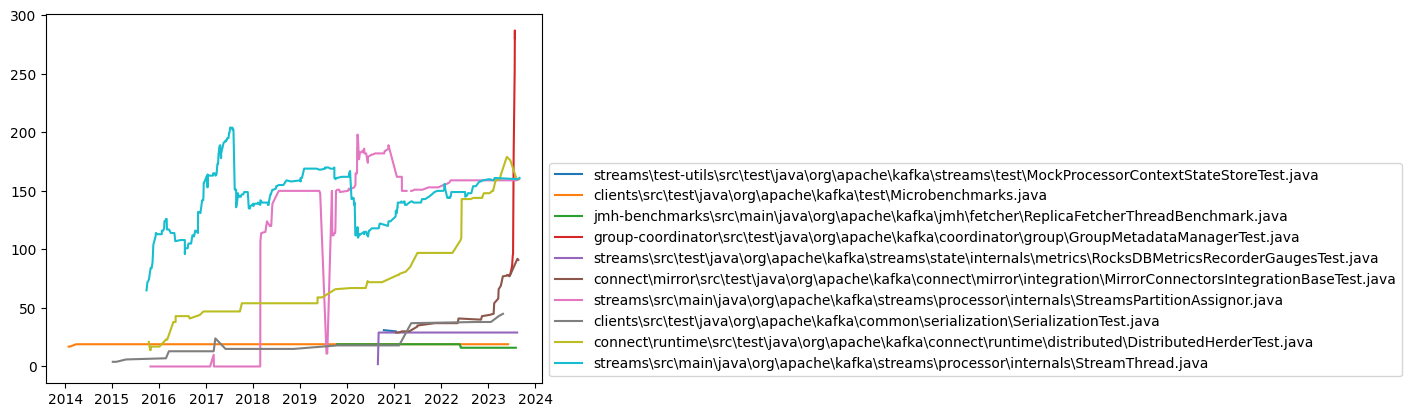

In [15]:
# in-depth complexity analysis on ten files
hotspots = [
    "streams\\test-utils\\src\\test\\java\\org\\apache\\kafka\\streams\\test\\MockProcessorContextStateStoreTest.java",
    "clients\\src\\test\\java\\org\\apache\\kafka\\test\\Microbenchmarks.java",
    "jmh-benchmarks\\src\\main\\java\\org\\apache\\kafka\\jmh\\fetcher\\ReplicaFetcherThreadBenchmark.java",
    "group-coordinator\\src\\test\\java\\org\\apache\\kafka\\coordinator\\group\\GroupMetadataManagerTest.java",
    "streams\\src\\test\\java\\org\\apache\\kafka\\streams\\state\\internals\\metrics\\RocksDBMetricsRecorderGaugesTest.java",
    "connect\\mirror\\src\\test\\java\\org\\apache\\kafka\\connect\\mirror\\integration\\MirrorConnectorsIntegrationBaseTest.java",
    "streams\\src\\main\\java\\org\\apache\\kafka\\streams\\processor\\internals\\StreamsPartitionAssignor.java",
    "clients\\src\\test\\java\\org\\apache\\kafka\\common\\serialization\\SerializationTest.java",
    "connect\\runtime\\src\\test\\java\\org\\apache\\kafka\\connect\\runtime\\distributed\\DistributedHerderTest.java",
    "streams\\src\\main\\java\\org\\apache\\kafka\\streams\\processor\\internals\\StreamThread.java",
]

X = []
Y = []
for h in hotspots:
    x = []
    y = []
    for c in Repository('./kafka/', filepath=h).traverse_commits():
        modified_file = next(
            filter(lambda f: h.endswith(f.filename), c.modified_files), None)
        x.append(c.committer_date)
        y.append(modified_file.complexity if modified_file is not None else 0)
    X.append(x)
    Y.append(y)
    plt.plot(x, y, label=h)
plt.legend(bbox_to_anchor=(1, 0), loc="lower left")
plt.show()